<a href="https://colab.research.google.com/github/abhay-2108/Waste-Management-using-CNN-Bayesian-Optimization-/blob/main/waste_management_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install torch torchvision scikit-learn numpy matplotlib seaborn tqdm optuna


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score, precision_score, recall_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm import tqdm
import optuna  # For Bayesian optimization

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
print(device)

cpu


In [ ]:
%pip install os

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Dataset Paths
import os
dataset_path = "DATASET"
train_dir = os.path.join(dataset_path, "TRAIN")
val_dir = os.path.join(dataset_path, "TEST")  # Using TEST as validation set

In [ ]:
# Data Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomRotation(30),  # Random rotation between -30 to +30 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Flip image with 50% probability
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Vary colors
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Random affine transformations
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


In [ ]:
# Load Data
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

# Image Visualization

C:\Users\hp\AppData\Local\Temp\ipykernel_25532\3839377508.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_dataset.classes, y=class_counts, palette="viridis")


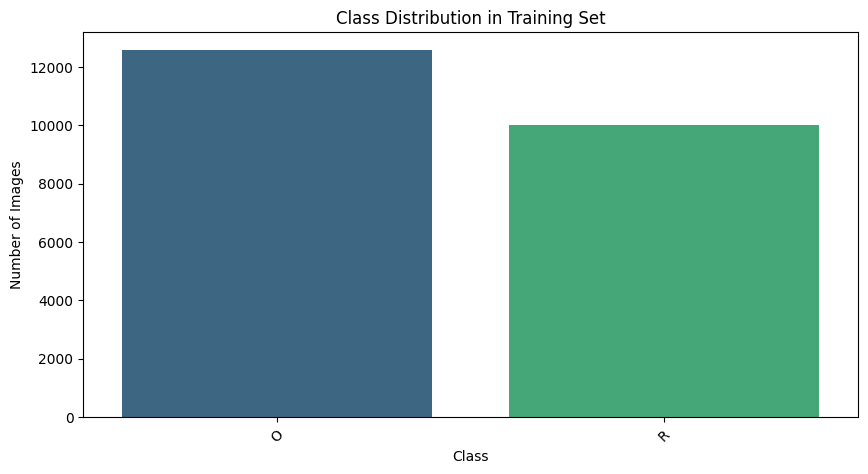

In [ ]:
# Helps identify class imbalance.
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names and counts
class_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in train_dataset.classes]

# Plot the class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=train_dataset.classes, y=class_counts, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Set")
plt.show()


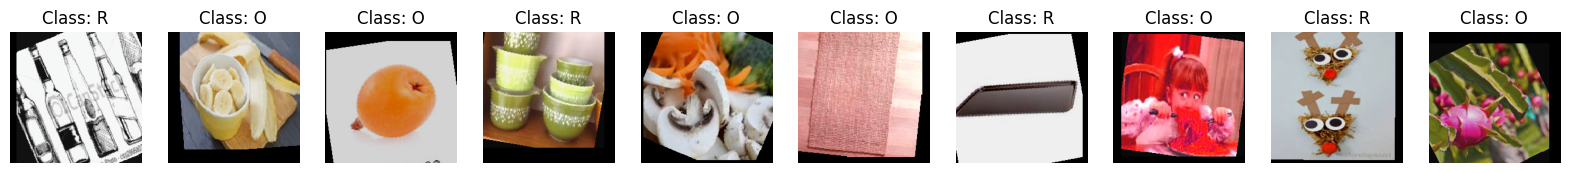

In [ ]:
# Displays a few random images with their labels.
import torchvision.utils as vutils

# Function to display sample images
def show_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    indices = np.random.randint(0, len(dataset), size=num_images)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalization
        img = np.clip(img, 0, 1)  # Clip values between 0 and 1

        axes[i].imshow(img)
        axes[i].set_title(f"Class: {train_dataset.classes[label]}")
        axes[i].axis("off")

    plt.show()

# Show random images from the training set
show_images(train_dataset)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

train_dir = r"\AI WASTE MANGE\DATASET\TRAIN"

image_shapes = []
for img_name in os.listdir(train_dir):
    img_path = os.path.join(train_dir, img_name)

    if os.path.isdir(img_path):
        continue
    try:
        with Image.open(img_path) as img:
            image_shapes.append(img.size)
    except Exception as e:
        print(f"Skipping {img_name}: {e}")

if image_shapes:
    image_shapes = np.array(image_shapes)

    plt.figure(figsize=(10, 5))
    plt.scatter(image_shapes[:, 0], image_shapes[:, 1], alpha=0.5)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image Size Distribution")
    plt.show()
else:
    print("No valid images found in the directory.")


No valid images found in the directory.


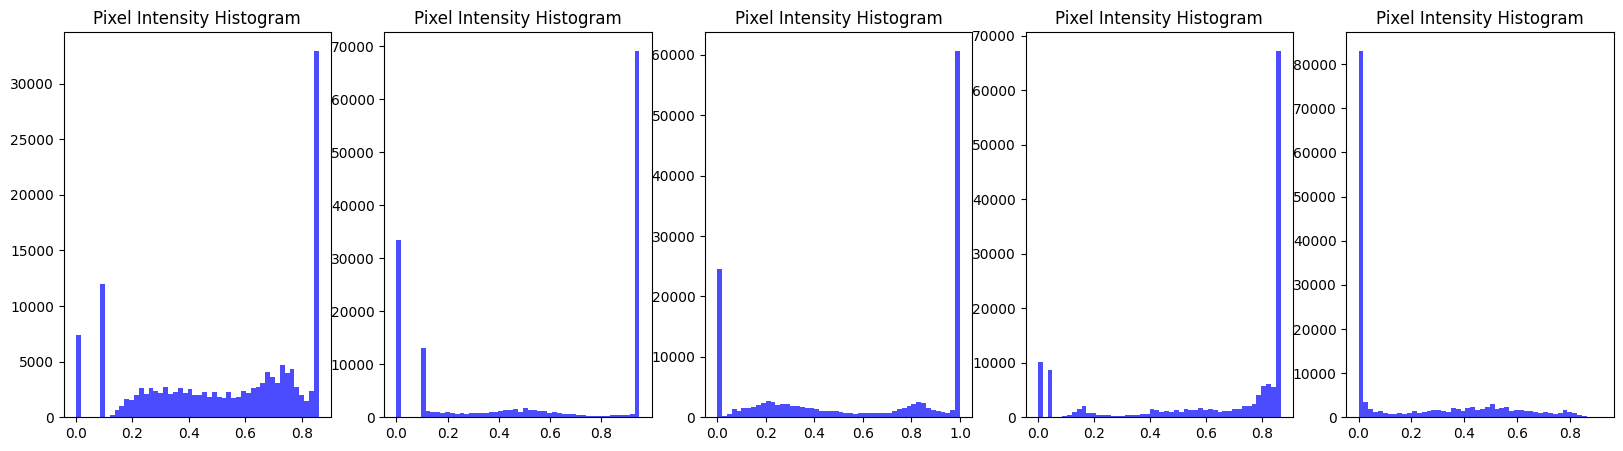

In [ ]:
# Function to plot pixel intensity distribution
def plot_pixel_distribution(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i in range(num_samples):
        img, _ = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to NumPy
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalization
        img = np.clip(img, 0, 1)

        axes[i].hist(img.ravel(), bins=50, color="blue", alpha=0.7)
        axes[i].set_title("Pixel Intensity Histogram")

    plt.show()

plot_pixel_distribution(train_dataset)


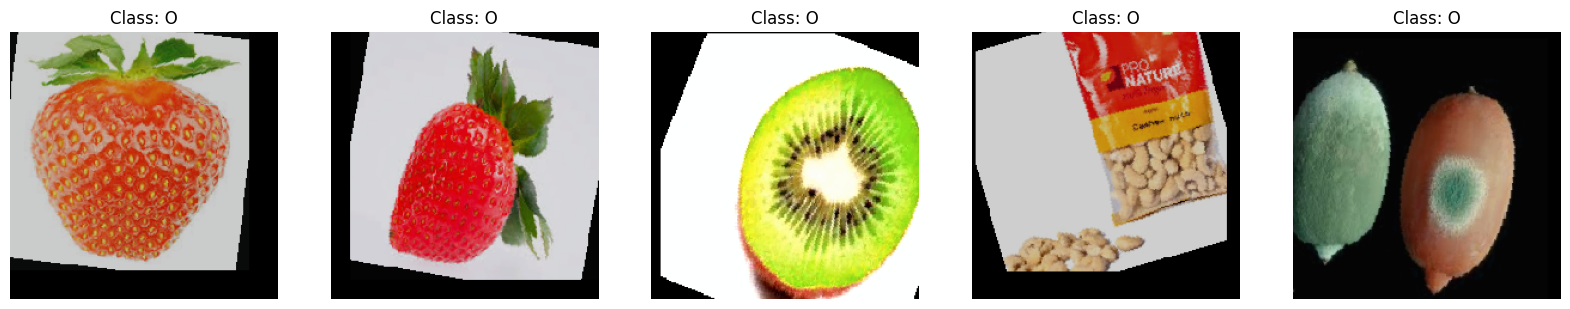

In [ ]:
#Ensures that augmentations are applied correctly.
def visualize_augmentations(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalization
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Class: {dataset.classes[label]}")
        axes[i].axis("off")

    plt.show()

visualize_augmentations(train_dataset)


In [ ]:
batch_size = 32  # Adjust batch size to avoid memory issues
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
import optuna

# Define the objective function for optimization
def objective(trial):
    # Search space for hyperparameters
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    num_filters = trial.suggest_categorical("num_filters", [32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])

    # Data loaders (Re-create with different batch size)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Define a new model with trial parameters
    class OptimizedCNN(nn.Module):
        def __init__(self, num_classes):
            super(OptimizedCNN, self).__init__()
            self.conv_layers = nn.Sequential(
                nn.Conv2d(3, num_filters, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),

                nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),

                nn.Conv2d(num_filters * 2, num_filters * 4, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            self.fc_layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_filters * 4 * 28 * 28, 512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, num_classes)
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = self.fc_layers(x)
            return x

    # Initialize model
    model = OptimizedCNN(len(train_dataset.classes)).to(device)

    # Define loss function
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Choose optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr)

    # Train the model for a few epochs (to speed up Optuna)
    for epoch in range(3):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy  # Optuna will try to maximize accuracy


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch

# Get class labels from dataset
labels = [label for _, label in train_dataset]

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

# Convert to tensor for PyTorch
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Now define the loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
# Create a study and optimize
study = optuna.create_study(direction="maximize")  # We want to maximize accuracy
study.optimize(objective, n_trials=20)

print("Best Hyperparameters:", study.best_params)


[I 2025-03-22 22:52:16,571] A new study created in memory with name: no-name-1805d2a5-45c5-4ee5-9c22-19b56f4286ce
C:\Users\hp\AppData\Local\Temp\ipykernel_25532\2185856127.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-03-23 01:39:24,489] Trial 0 finished with value: 84.24194190210903 and parameters: {'lr': 6.0162266734094255e-05, 'batch_size': 16, 'dropout_rate': 0.21445873737982143, 'num_filters': 64, 'optimizer': 'Adam'}. Best is trial 0 with value: 84.24194190210903.
[I 2025-03-23 03:14:57,607] Trial 1 finished with value: 84.16235575009948 and parameters: {'lr': 0.00021847006404769582, 'batch_size': 16, 'dropout_rate': 0.3427262289137669, 'num_filters': 64, 'optimizer': 'SGD'}. Best is trial 0 with value: 84.24194190210903.
[I 2025-03-23 03:48:12,267] Trial 2 fin

Best Hyperparameters: {'lr': 0.0002457012561502338, 'batch_size': 64, 'dropout_rate': 0.2887915419451806, 'num_filters': 128, 'optimizer': 'SGD'}


In [ ]:
# Compute Class Weights
train_targets = np.array(train_dataset.targets)
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets), y=train_targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [ ]:
# Initialize Model
num_classes = len(train_dataset.classes)
model = WasteClassifierCNN(num_classes).to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}')

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        progress_bar.set_postfix({'loss': f'{running_loss/(total/batch_size):.3f}', 'acc': f'{100.*correct/total:.2f}%'})

    return running_loss / len(train_loader), 100. * correct / total

In [ ]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    return running_loss / len(val_loader), np.array(all_preds), np.array(all_labels), np.array(all_probs)


In [ ]:
# Training Loop
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)
    val_loss, val_preds, val_labels, val_probs = evaluate_model(model, val_loader, criterion)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_custom_cnn.pth')
        print("New best model saved!")

Validation: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch 1 - Train Loss: 0.4621, Train Acc: 79.04%
Validation Loss: 0.3841
New best model saved!


Validation: 100%|██████████| 79/79 [00:40<00:00,  1.94it/s]


Epoch 2 - Train Loss: 0.4123, Train Acc: 81.92%
Validation Loss: 0.3615
New best model saved!


Validation: 100%|██████████| 79/79 [00:40<00:00,  1.94it/s]


Epoch 3 - Train Loss: 0.3892, Train Acc: 83.03%
Validation Loss: 0.3695


Validation: 100%|██████████| 79/79 [00:40<00:00,  1.95it/s]


Epoch 4 - Train Loss: 0.3743, Train Acc: 83.93%
Validation Loss: 0.3364
New best model saved!


Validation: 100%|██████████| 79/79 [00:40<00:00,  1.96it/s]


Epoch 5 - Train Loss: 0.3612, Train Acc: 84.90%
Validation Loss: 0.3035
New best model saved!


Validation: 100%|██████████| 79/79 [00:42<00:00,  1.86it/s]


Epoch 6 - Train Loss: 0.3528, Train Acc: 85.25%
Validation Loss: 0.3237


Validation: 100%|██████████| 79/79 [01:26<00:00,  1.10s/it]


Epoch 7 - Train Loss: 0.3416, Train Acc: 85.94%
Validation Loss: 0.2950
New best model saved!


Validation: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it]


Epoch 8 - Train Loss: 0.3360, Train Acc: 86.29%
Validation Loss: 0.2823
New best model saved!


Validation: 100%|██████████| 79/79 [01:33<00:00,  1.18s/it] 


Epoch 9 - Train Loss: 0.3316, Train Acc: 86.18%
Validation Loss: 0.2738
New best model saved!


Validation: 100%|██████████| 79/79 [01:32<00:00,  1.17s/it]

Epoch 10 - Train Loss: 0.3196, Train Acc: 86.87%
Validation Loss: 0.3099


In [ ]:
# Evaluation & Metrics Plotting
def plot_metrics(all_labels, all_preds, all_probs, classes):
    plt.figure(figsize=(10, 8))
    conf_matrix = confusion_matrix(all_labels, all_preds)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    plt.figure(figsize=(10, 8))
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(all_labels, all_probs):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [ ]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    print("\nEvaluating model...")
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class

    val_loss = running_loss / len(val_loader)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    return val_loss, all_preds, all_labels, all_probs


Evaluating model...


Validation: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it]



Final Classification Report:
              precision    recall  f1-score   support

           O     0.8469    0.9636    0.9015      1401
           R     0.9445    0.7806    0.8548      1112

    accuracy                         0.8826      2513
   macro avg     0.8957    0.8721    0.8781      2513
weighted avg     0.8901    0.8826    0.8808      2513



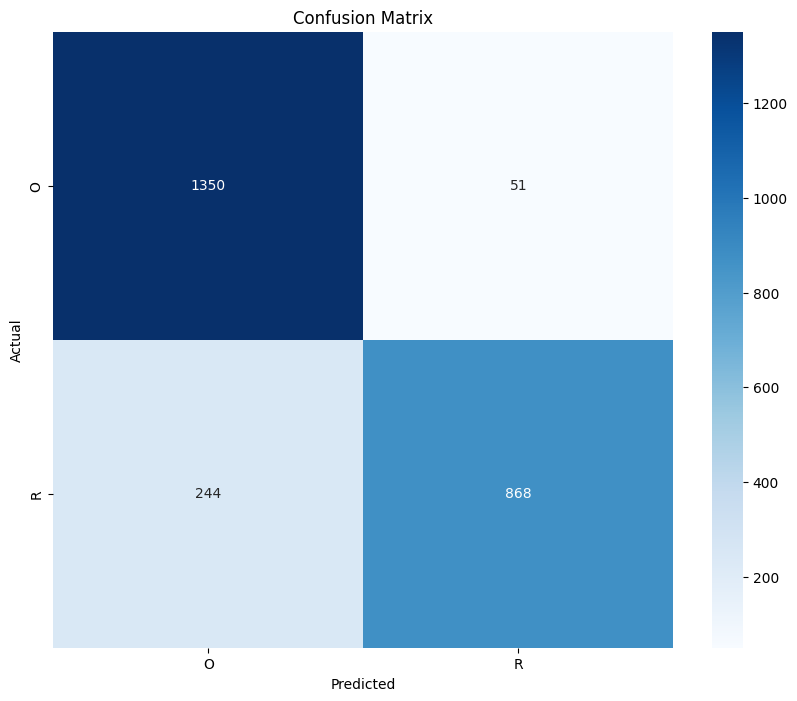

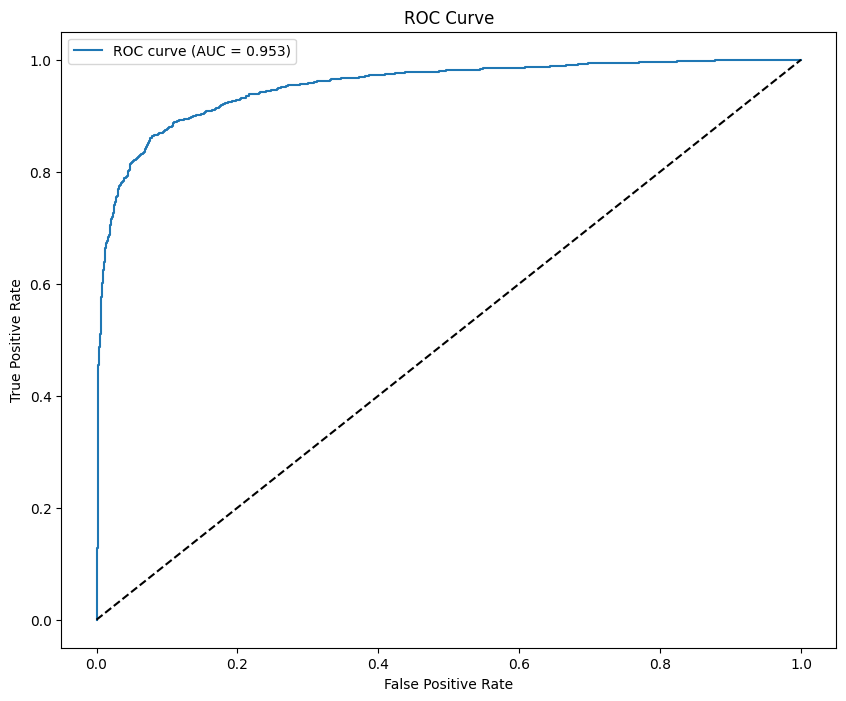

In [ ]:
# Final Evaluation
val_loss, final_preds, final_labels, final_probs = evaluate_model(model, val_loader, criterion)

print("\nFinal Classification Report:")
print(classification_report(final_labels, final_preds, target_names=train_dataset.classes, digits=4))

plot_metrics(final_labels, final_preds, final_probs, train_dataset.classes)